<a href="https://colab.research.google.com/github/puneethkumarvydya/Capstone-Project/blob/Gopi's-Branch/Capstone_Project_AIML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
#### Add your code here ####
os.chdir('/content/drive/My Drive')
path = '.'

In [6]:
pip install pydicom

     |████████████████████████████████| 1.9MB 2.7MB/s 


In [ ]:
import os
count = 0
d = "stage_2_train_images"
for path in os.listdir(d):
    if os.path.isfile(os.path.join(d, path)):
        count += 1
print("Total Training images:")
print(count)

Total Training images:
26684


In [ ]:
import os
count = 0
d = "stage_2_test_images"
for path in os.listdir(d):
    if os.path.isfile(os.path.join(d, path)):
        count += 1
print("Total Testing images:")
print(count)

Total Testing images:
3000


In [ ]:
import os
import pydicom as dicom

image_path = 'stage_2_train_images/000fe35a-2649-43d4-b027-e67796d412e0.dcm'
ds = dicom.dcmread(image_path)

print(ds.pixel_array.shape)

(1024, 1024)


In [ ]:
import pickle

d = "stage_2_train_images"
data = ""
for path in os.listdir(d):
    if os.path.isfile(os.path.join(d, path)):
        ds = dicom.dcmread(d + "/" + path)
        imgshape = ds.pixel_array.shape
        data = data + path + ',' + str(imgshape) + ',' + '\n'
        with open('images_train_shape.csv', 'wb') as fp:
            pickle.dump(data, fp)

In [ ]:
import pickle

d = "stage_2_test_images"
data = ""
for path in os.listdir(d):
    if os.path.isfile(os.path.join(d, path)):
        ds = dicom.dcmread(d + "/" + path)
        imgshape = ds.pixel_array.shape
        data = data + path + ',' + str(imgshape) + ',' + '\n'
        with open('images_test_shape.csv', 'wb') as fp:
            pickle.dump(data, fp)

In [ ]:
min_size = os.path.getsize('stage_2_train_images/000db696-cf54-4385-b10b-6b16fbb3f985.dcm')
max_size = os.path.getsize('stage_2_train_images/000db696-cf54-4385-b10b-6b16fbb3f985.dcm')
d = "stage_2_train_images"
for path in os.listdir(d):
    if os.path.isfile(os.path.join(d, path)):
        size = os.path.getsize(d + "/" + path)
        if size < min_size:
            min_size = size
            min_filename = path
        if size > max_size:
            max_size = size
            max_filename = path
            
print(min_size)
print(max_size)

46234
370560


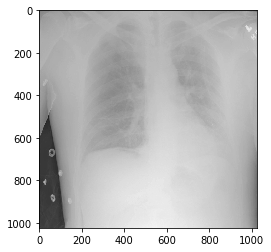

In [ ]:
import pydicom as dicom
import matplotlib.pylab as plt

image_path = 'stage_2_train_images/' + min_filename
ds = dicom.dcmread(image_path)

plt.imshow(ds.pixel_array, cmap='gray')

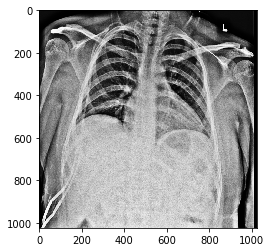

In [ ]:
image_path = 'stage_2_train_images/' + max_filename
ds = dicom.dcmread(image_path)

plt.imshow(ds.pixel_array, cmap='gray')

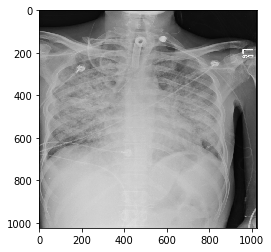

In [ ]:
image_path = 'stage_2_train_images/000fe35a-2649-43d4-b027-e67796d412e0.dcm'
ds = dicom.dcmread(image_path)

plt.imshow(ds.pixel_array,cmap='gray')

In [ ]:
min_size = os.path.getsize('stage_2_test_images/0000a175-0e68-4ca4-b1af-167204a7e0bc.dcm')
max_size = os.path.getsize('stage_2_test_images/0000a175-0e68-4ca4-b1af-167204a7e0bc.dcm')
d = "stage_2_test_images"
for path in os.listdir(d):
    if os.path.isfile(os.path.join(d, path)):
        size = os.path.getsize(d + "/" + path)
        if size < min_size:
            min_size = size
            min_filename = path
        if size > max_size:
            max_size = size
            max_filename = path
            
print(min_size)
print(max_size)

46242
189830


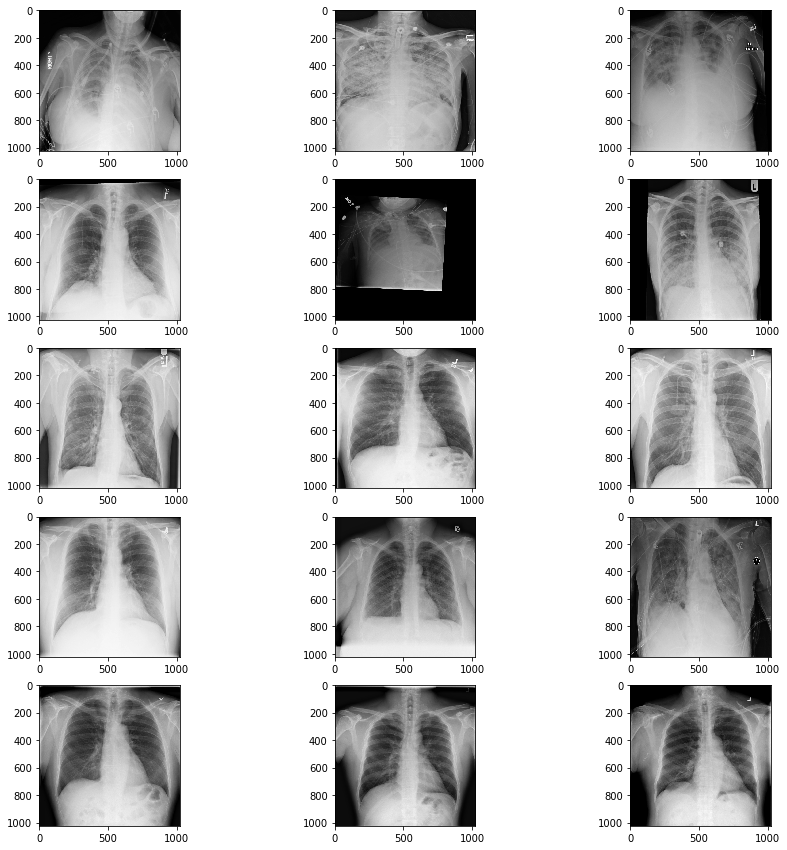

In [ ]:
import pydicom as dicom
import matplotlib.pylab as plt
import os

count = 1
plt.figure(figsize= (15,15))
d = "images"
for path in os.listdir(d):
    if os.path.isfile(os.path.join(d, path)):
        ds = dicom.dcmread(d + "/" + path)
        plt.subplot(5,3,count)
        plt.imshow(ds.pixel_array,cmap='gray')
        count += 1

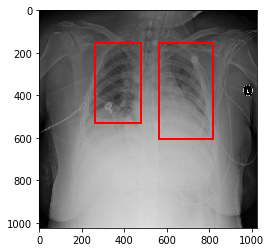

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pydicom as dicom

fig,ax = plt.subplots(1)
image_path = 'stage_2_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm'
ds = dicom.dcmread(image_path)
ax.imshow(ds.pixel_array, cmap='gray')
rect1 = patches.Rectangle((264, 152), 213, 379, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect1)
rect2 = patches.Rectangle((562, 152), 256, 453, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect2)

plt.show()

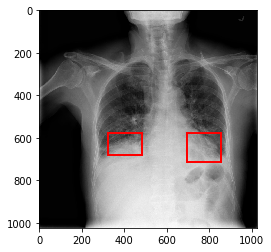

In [ ]:
fig,ax = plt.subplots(1)
image_path = 'stage_2_train_images/00704310-78a8-4b38-8475-49f4573b2dbb.dcm'
ds = dicom.dcmread(image_path)
ax.imshow(ds.pixel_array, cmap='gray')
rect1 = patches.Rectangle((323, 577), 160, 104, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect1)
rect2 = patches.Rectangle((695, 575), 162, 137, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect2)

plt.show()

In [ ]:
image_path = 'stage_2_train_images/000db696-cf54-4385-b10b-6b16fbb3f985.dcm'
ds = dicom.dcmread(image_path, force = True)

ds
#plt.imshow(ds.pixel_array,cmap='gray')

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.4475.1517874307.936345
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.4475.1517874307.936345
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

In [ ]:
dat1 = ds[16,32].value
dat2 = ds[16,64].value
dat3 = ds[16,4112].value
dat4 = ds[24,21].value

In [ ]:
import pickle

d = "stage_2_train_images"
data = ""
for path in os.listdir(d):
    if os.path.isfile(os.path.join(d, path)):
        ds = dicom.dcmread(d + "/" + path)
        dat1 = ds[16,32].value
        dat2 = ds[16,64].value
        dat3 = ds[16,4112].value
        dat4 = ds[24,21].value
        data = data + dat1 + ',' + dat2 + ',' + dat3 + ',' + dat4 + ',' + '\n'
        with open('images_more_data_train.csv', 'wb') as fp:
            pickle.dump(data, fp)

In [ ]:
d = "stage_2_test_images"
data = ""
for path in os.listdir(d):
    if os.path.isfile(os.path.join(d, path)):
        ds = dicom.dcmread(d + "/" + path)
        dat1 = ds[16,32].value
        dat2 = ds[16,64].value
        dat3 = ds[16,4112].value
        dat4 = ds[24,21].value
        data = data + dat1 + ',' + dat2 + ',' + dat3 + ',' + dat4 + ',' + '\n'
        with open('images_more_data_test.csv', 'wb') as fp:
            pickle.dump(data, fp)

In [ ]:
count

3000

In [ ]:
import pandas as pd

class_info = pd.read_csv("stage_2_detailed_class_info.csv")

In [ ]:
class_info.shape

(30227, 2)

In [ ]:
class_info.head(10)

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
6,00569f44-917d-4c86-a842-81832af98c30,No Lung Opacity / Not Normal
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,No Lung Opacity / Not Normal
8,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity
9,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity


In [ ]:
class_info.describe()

,patientId,class
count,30227,30227
unique,26684,3
top,3239951b-6211-4290-b237-3d9ad17176db,No Lung Opacity / Not Normal
freq,4,11821


In [ ]:
class_info['class'].unique()

array(['No Lung Opacity / Not Normal', 'Normal', 'Lung Opacity'],
      dtype=object)

In [ ]:
class_info['class'].value_counts()

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

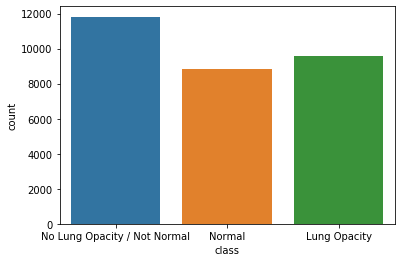

In [ ]:
import seaborn as sb

sb.countplot(x='class',data=class_info)

In [ ]:
class_info.isnull().sum()

patientId    0
class        0
dtype: int64

In [ ]:
train_labels = pd.read_csv("stage_2_train_labels.csv")

In [ ]:
train_labels.shape

(30227, 6)

In [ ]:
train_labels.head(10)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


In [ ]:
train_labels.describe()

,x,y,width,height,Target
count,9555.000000,9555.000000,9555.000000,9555.000000,30227.000000
mean,394.047724,366.839560,218.471376,329.269702,0.316108
std,204.574172,148.940488,59.289475,157.750755,0.464963
min,2.000000,2.000000,40.000000,45.000000,0.000000
25%,207.000000,249.000000,177.000000,203.000000,0.000000
50%,324.000000,365.000000,217.000000,298.000000,0.000000
75%,594.000000,478.500000,259.000000,438.000000,1.000000
max,835.000000,881.000000,528.000000,942.000000,1.000000


In [ ]:
train_labels['Target'].unique()

array([0, 1], dtype=int64)

In [ ]:
train_labels['Target'].value_counts()

0    20672
1     9555
Name: Target, dtype: int64

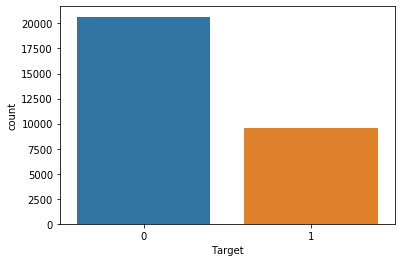

In [ ]:
sb.countplot(x='Target',data=train_labels)

In [ ]:
train_labels.isnull().sum()

patientId        0
x            20672
y            20672
width        20672
height       20672
Target           0
dtype: int64

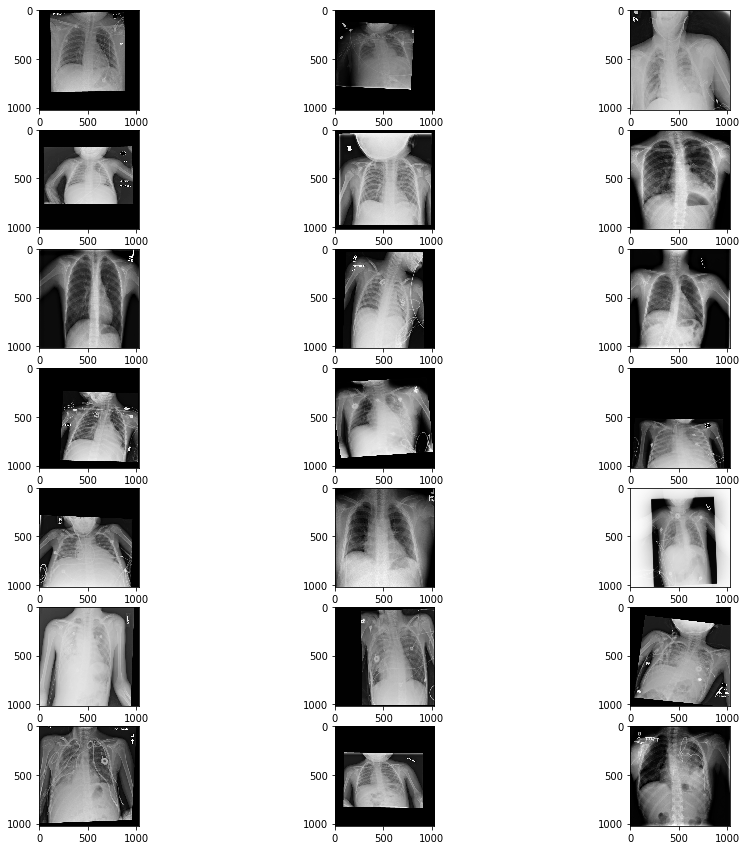

In [ ]:
import pydicom as dicom
import matplotlib.pylab as plt
import os

count = 1
plt.figure(figsize= (15,15))
d = "stage_2_train_images"
for path in os.listdir(d):
    if os.path.isfile(os.path.join(d, path)):
        ds = dicom.dcmread(d + "/" + path)
        dat = ds[16,4112].value 
        if int(dat) < 15:
            plt.subplot(7,3,count)
            plt.imshow(ds.pixel_array,cmap='gray')
            count += 1
            if count == 22:
                break

In [3]:
import numpy as np
import csv

label_csv = 'stage_2_train_labels.csv'
image_height = 1024
image_width = 1024

IMAGE_SIZE = 128 

with open(label_csv, "r") as f:
  
  y_train = np.zeros((sum(1 for line in f), 4))
  X_train = []
  f.seek(0)
  data = csv.reader(f, delimiter=',')
  for index, row in enumerate(data):
    for i, r in enumerate(row[1:7]):
      row[i+1] = int(r)
    path, x0, y0, x1, y1, target = row       
    y_train[index, 0] = x0 * IMAGE_SIZE / image_width                 
    y_train[index, 1] = y0 * IMAGE_SIZE / image_height                
    y_train[index, 2] = x1 * IMAGE_SIZE / image_width          
    y_train[index, 3] = y1 * IMAGE_SIZE / image_height         

    X_train.append(path) 

In [4]:
X_train[:5]

['0004cfab-14fd-4e49-80ba-63a80b6bddd6',
 '00313ee0-9eaa-42f4-b0ab-c148ed3241cd',
 '00322d4d-1c29-4943-afc9-b6754be640eb',
 '003d8fa0-6bf1-40ed-b54c-ac657f8495c5',
 '00436515-870c-4b36-a041-de91049b9ab4']

In [7]:
import pydicom as dicom
# Pick a random image to check how it looks
d = "stage_2_train_images"
imgnum = 25
filename = X_train[imgnum]
unscaled = dicom.dcmread(d + "/" + filename + ".dcm")
region = y_train[imgnum]
image_height, image_width = unscaled.pixel_array.shape
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int(region[2] * image_width / IMAGE_SIZE)
y1 = int(region[3] * image_height / IMAGE_SIZE)

In [8]:
print(filename)

0174c4bb-28f5-41e3-a13f-a396badc18bd


In [9]:
print(x0)
print(y0)
print(x1)
print(y1)

155
182
273
501


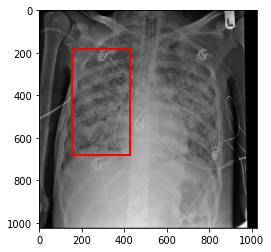

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig,ax = plt.subplots(1)
ax.imshow(unscaled.pixel_array,cmap='gray')
rect = patches.Rectangle((x0, y0), x1, y1, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)

plt.show()

In [11]:
from skimage.transform import resize

image_path = 'stage_2_train_images/000fe35a-2649-43d4-b027-e67796d412e0.dcm'
ds = dicom.dcmread(image_path)

print(ds.pixel_array.shape)

(1024, 1024)


In [12]:
resized_img = resize(ds.pixel_array, (IMAGE_SIZE, IMAGE_SIZE), anti_aliasing=True)

In [13]:
print(resized_img.shape)

(128, 128)


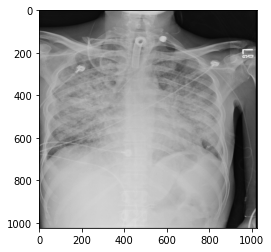

In [14]:
plt.imshow(ds.pixel_array,cmap='gray')

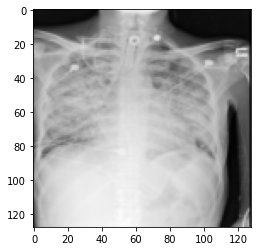

In [15]:
plt.imshow(resized_img,cmap='gray')

In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input
from skimage.transform import resize

from tqdm import tqdm

d = "stage_2_train_images"

for i, f in tqdm(enumerate(X_train)):
  img = dicom.dcmread(d + "/" + f + ".dcm")
  resized_img = resize(img.pixel_array, (IMAGE_SIZE, IMAGE_SIZE), anti_aliasing=True)
  X_train[i] = preprocess_input(np.array(resized_img, dtype=np.float32))

681it [06:32,  1.74it/s]

In [ ]:
import pickle

with open('/content/drive/My Drive/xtrainpreprocessed', 'wb') as fp:
    pickle.dump(X_train, fp)

In [ ]:
X_train_rgb = np.repeat(X_train[..., np.newaxis], 3, -1)

In [ ]:
print(X_train[0])

[[-0.99996924 -0.9999385  -0.9999462  ... -0.9999385  -0.9999385
  -0.9999385 ]
 [-0.99996924 -0.9999385  -0.9999385  ... -0.9999385  -0.9999385
  -0.9999385 ]
 [-0.99996924 -0.9999385  -0.9999154  ... -0.9999385  -0.9999385
  -0.9999308 ]
 ...
 [-0.99990773 -0.999877   -0.999877   ... -0.9998462  -0.99981546
  -0.99981546]
 [-0.99990773 -0.999877   -0.999877   ... -0.9998462  -0.9998462
  -0.9998462 ]
 [-0.9999231  -0.999877   -0.999877   ... -0.9998462  -0.9998462
  -0.9998462 ]]


In [ ]:
print(X_train[100])

[[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -0.99996924 -0.99996924 ... -1.         -1.
  -1.        ]
 [-1.         -0.99996924 -0.99996924 ... -1.         -1.
  -1.        ]
 [-1.         -0.99996924 -0.99996924 ... -1.         -1.
  -1.        ]]


In [ ]:
X_train = np.array(X_train)

In [ ]:
X_train.shape

(9555, 128, 128)

In [ ]:
X_train_rgb = np.array(X_train_rgb)

In [ ]:
X_train_rgb.shape

(9555, 128, 128, 3)

In [ ]:
y_train

array([[33.   , 19.   , 26.625, 47.375],
       [70.25 , 19.   , 32.   , 56.625],
       [40.375, 72.125, 20.   , 13.   ],
       ...,
       [23.125, 37.25 , 28.5  , 47.375],
       [71.25 , 49.125, 32.625, 43.125],
       [29.125, 53.   , 25.125, 44.5  ]])

In [ ]:
y_train.shape

(9555, 4)

In [ ]:
from sklearn.model_selection import train_test_split

# Split train and valid
X_training, X_valid, y_training, y_valid = train_test_split(X_train_rgb, y_train, test_size=0.15, random_state=5)

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Reshape

ALPHA = 1.0 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet
    # Do not include classification (top) layer

    # to freeze layers, except the new top layer, of course, which will be added below
    for layer in model.layers:
        layer.trainable = trainable

    # Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
    x0 = model.layers[-1].output
    x1 = Conv2D(4, kernel_size=4, name="coords")(x0)
    # In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
    x2 = Reshape((4,))(x1) # These are the 4 predicted coordinates of one BBox

    return Model(inputs=model.input, outputs=x2)

In [ ]:
def IOU(y_true, y_pred):
    intersections = 0
    unions = 0
    # set the types so we are sure what type we are using

    gt = y_true
    pred = y_pred
    # Compute interection of predicted (pred) and ground truth (gt) bounding boxes
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height

    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

    # Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
      if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
        intersections += intersection[j]
        unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + tensorflow.keras.backend.epsilon()), 4)
    # This must match the type used in py_func
    iou = iou.astype(np.float32)
    return iou

In [ ]:
def IoU(y_true, y_pred):
    iou = tensorflow.py_function(IOU, [y_true, y_pred], Tout=tensorflow.float32)
    return iou

In [ ]:
model = create_model(False) # Arg is False, if you want to freeze lower layers for fast training (but low accuracy)
model.summary() # Print summary

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128 

In [ ]:
import tensorflow

In [ ]:
model.compile(loss="mean_squared_error", optimizer="adam", metrics=[IoU])

In [ ]:
# Use earlystopping
callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_IoU', patience=5, min_delta=0.01)

# Fit the model
model.fit(X_training, y_training, validation_data=(X_valid, y_valid), epochs=10, batch_size=32, callbacks=[callback])

Train on 8121 samples, validate on 1434 samples
Epoch 1/10
8121/8121 [==============================] - 248s 31ms/sample - loss: 334.0218 - IoU: 0.1362 - val_loss: 1367.6367 - val_IoU: 0.1987
Epoch 2/10
2464/8121 [========>.....................] - ETA: 2:45 - loss: 263.1771 - IoU: 0.1530